# Init models and load weights

In [1]:
# first download the weights, using the link in Readme.md
vae_ckpt_path = "vae_ft_checkpoint.pt"
switti_state_dict_path = "model_state_dict.pt"

In [2]:
import torch

from models import VAR, VQVAE, TVARPipeline, FrozenCLIPEmbedder
from utils.arg_util import RESOLUTION_PATCH_NUMS_MAPPING

resolution = 512
device = 'cuda:0'

patch_nums = tuple((int(x) for x in RESOLUTION_PATCH_NUMS_MAPPING[resolution].split('_')))
vae = VQVAE(v_patch_nums=patch_nums).to(device, torch.bfloat16)
vae.load_state_dict(torch.load(vae_ckpt_path, map_location='cpu'),
                    strict=True,
                   )
heads = depth = 30
width = depth * 64

var = VAR(
    depth=depth,
    embed_dim=width,
    num_heads=heads,
    attn_l2_norm=True,
    patch_nums=patch_nums,
    rope=True,
    rope_theta=10000,
    rope_size=128,
    use_swiglu_ffn=True,
    use_ar=False,
).to(device, torch.bfloat16)
var.load_state_dict(torch.load(switti_state_dict_path, map_location='cpu'),
                    strict=True,
                   )

text_encoder_path = "openai/clip-vit-large-patch14"
text_encoder_2_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
text_encoder = FrozenCLIPEmbedder(text_encoder_path, device).to(torch.bfloat16)
text_encoder_2 = FrozenCLIPEmbedder(text_encoder_2_path, device).to(torch.bfloat16)
pipe = TVARPipeline(var, vae, text_encoder, text_encoder_2, device)

/var/tmp/ipykernel_578975/2189498608.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt_path, map_location='cpu'),



[constructor]  ==== fused_if_available=True (fusing_add_ln=0/30, fusing_mlp=0/30) ==== 
    [VAR config ] embed_dim=1920, num_heads=30, depth=30, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0 (tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]))



/var/tmp/ipykernel_578975/2189498608.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  var.load_state_dict(torch.load(switti_state_dict_path, map_location='cpu'),


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

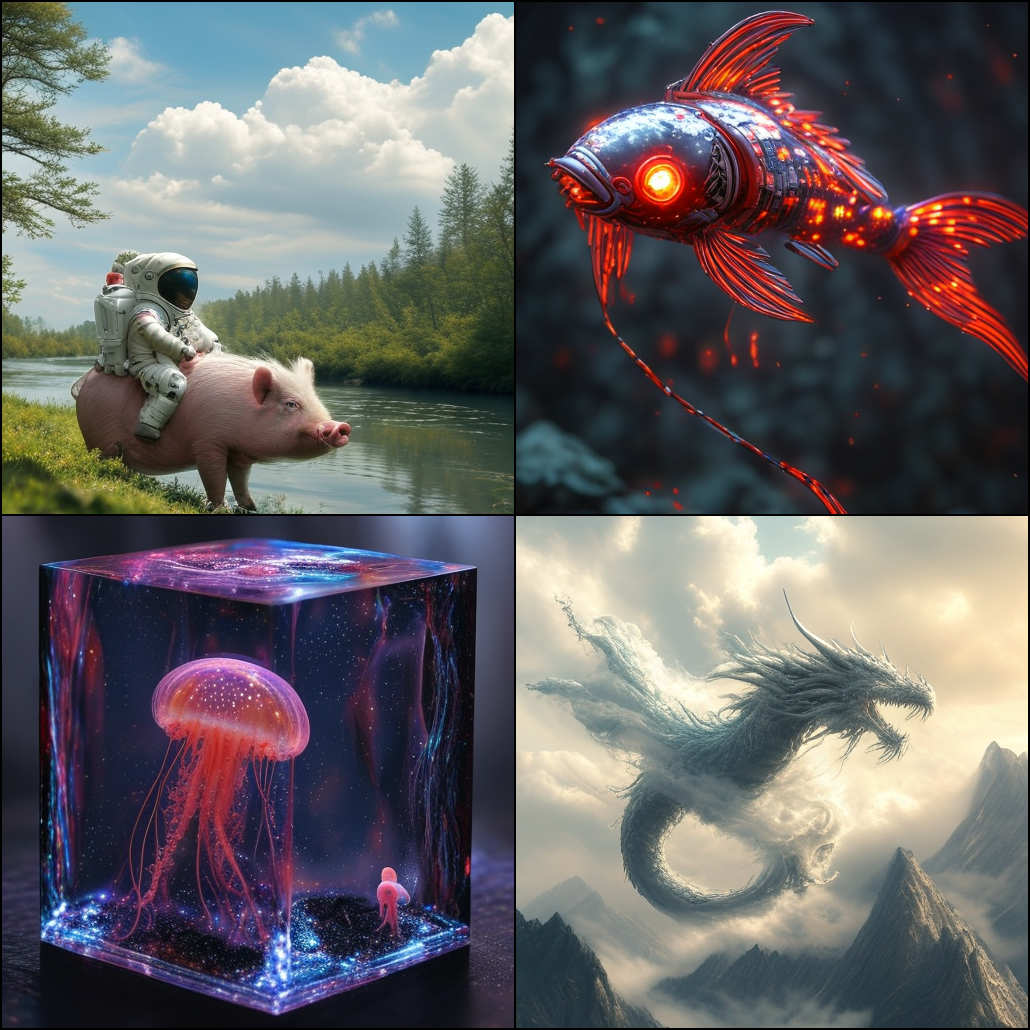

In [3]:
from torchvision.utils import make_grid
from calculate_metrics import to_PIL_image
import time

prompts = ["an astronaut rides a pig through in the forest. next to a river, with clouds in the sky",
           "flying robot koi fish with armour plating, neon glowing eyes and wiring, 4k, unreal engine, marvel comics style",
           "sci-fi cosmic diarama of a quasar and jellyfish in a resin cube, volumetric lighting, high resolution, hdr, sharpen, Photorealism",
           "A cloud dragon flying over mountains, its body swirling with the wind.",
          ]
images = pipe(prompts,
              cfg=4.0,
              top_k=600,
              top_p=0.95,
              more_smooth=True,
              return_pil=False,
              smooth_start_si=2,
              turn_off_cfg_start_si=8,
              seed=3,
             )
to_PIL_image(make_grid([img.float() for img in images], nrow=2))